In [75]:
pip install pandas numpy scikit-learn matplotlib

Note: you may need to restart the kernel to use updated packages.


In [76]:
pip install pandas numpy scikit-learn snntorch pyswarms scikit-fuzzy torch

Note: you may need to restart the kernel to use updated packages.


In [77]:
pip install snntorch pyswarms scikit-fuzzy

Note: you may need to restart the kernel to use updated packages.


In [78]:
!pip install seaborn

In [80]:
# ------------------ Imports ------------------
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix, precision_score,
                             recall_score, classification_report, roc_auc_score)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from pyswarms.single.global_best import GlobalBestPSO
import snntorch as snn
import pickle, json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # if you need 3D plots later
import random

# ------------------ Reproducibility ------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ------------------ Device ------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# ------------------ Load & Preprocess ------------------
df = pd.read_csv(r"C:\Users\HCI_Lab\Downloads\iotsensordata.csv", encoding='utf-8-sig')
df.columns = [col.strip().lower().replace("(", "_").replace(")", "_").replace(" ", "_").rstrip("_")
              for col in df.columns]
df.fillna(df.mean(numeric_only=True), inplace=True)

# Feature Engineering
df['moisture_temp'] = df['soil_moisture_%'] * df['temperature_°c']
df['rain_air'] = df['rainfall_mm'] * df['air_humidity__%']
df['moisture_rolling5'] = df['soil_moisture_%'].rolling(5, min_periods=1).mean()
df['temp_rolling5'] = df['temperature_°c'].rolling(5, min_periods=1).mean()
df.drop(columns=[col for col in ['ph', 'humidity_ph'] if col in df.columns], inplace=True)
df['status'] = df['status'].str.lower().map({'off': 0, 'on': 1})

# Train-test split
X = df.drop(columns=["status"]).values
y = df["status"].values
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=SEED
)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

# ------------------ Fuzzy + PCA ------------------
class FuzzyTransformer:
    def __init__(self, n_clusters=3):
        self.n_clusters = n_clusters
        self.centers_ = []

    def fit(self, X):
        self.centers_ = []
        for i in range(X.shape[1]):
            kmeans = KMeans(n_clusters=self.n_clusters, random_state=SEED).fit(
                X[:, i].reshape(-1, 1)
            )
            self.centers_.append(np.sort(kmeans.cluster_centers_.flatten()))
        return self

    def transform(self, X):
        sigma_sq = 2 * (0.1 ** 2)
        return np.concatenate([
            np.exp(-((X[:, i][:, None] - self.centers_[i]) ** 2) / sigma_sq)
            for i in range(X.shape[1])
        ], axis=1)

fuzzy_transformer = FuzzyTransformer().fit(X_train)
X_train_fuzzy = fuzzy_transformer.transform(X_train)
X_test_fuzzy = fuzzy_transformer.transform(X_test)

# 🔧 PCA with max allowed components (here 33)
pca = PCA(n_components=33)
X_train_pca = pca.fit_transform(X_train_fuzzy)
X_test_pca = pca.transform(X_test_fuzzy)

X_train_tensor = torch.tensor(X_train_pca, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_pca, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# ------------------ SNN Model ------------------
class SNNModel(nn.Module):
    def __init__(self, input_size, h1, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, h1)
        self.drop = nn.Dropout(0.1)          # 🔧 small dropout
        self.lif1 = snn.Leaky(beta=0.95, threshold=0.4)
        self.fc2 = nn.Linear(h1, output_size)

    def forward(self, x):
        mem = self.lif1.init_leaky()
        spk_sum = 0
        for _ in range(5):
            x1 = self.drop(self.fc1(x))      # 🔧 apply dropout on hidden layer
            spk, mem = self.lif1(x1, mem)
            spk_sum += self.fc2(spk)
        return spk_sum / 5

# ------------------ PSO Optimization ------------------
def fitness_function(hyperparams):
    accs = []
    input_size = X_train_tensor.shape[1]
    for h in hyperparams:
        h1 = int(h[0])
        lr = float(h[1])
        try:
            # sanity range
            if h1 < 16 or lr <= 0 or lr > 0.05:
                raise ValueError("Invalid hyperparameter range")

            model = SNNModel(input_size, h1, 2).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            criterion = nn.CrossEntropyLoss(weight=weights_tensor)

            # 🔧 more epochs for better fitness estimate
            for _ in range(10):  # was 3
                model.train()
                optimizer.zero_grad()
                out = model(X_train_tensor)
                loss = criterion(out, y_train_tensor)
                loss.backward()
                optimizer.step()

            model.eval()
            with torch.no_grad():
                pred = model(X_test_tensor).argmax(1)
                acc = accuracy_score(y_test_tensor.cpu(), pred.cpu())
                accs.append(1 - acc)  # PSO minimizes
        except Exception:
            accs.append(1.0)
    return np.array(accs)

# 🔧 wider bounds + more capacity
bounds = (np.array([48, 0.0008]),   # min h1, min lr
          np.array([224, 0.02]))    # max h1, max lr

options = {'c1': 1.4, 'c2': 1.4, 'w': 0.7}

optimizer = GlobalBestPSO(
    n_particles=10,
    dimensions=2,
    options=options,
    bounds=bounds
)
best_cost, best_pos = optimizer.optimize(fitness_function, iters=20)  # 🔧 20 iters
h1, lr = int(best_pos[0]), float(best_pos[1])
print(f"\n🎯 Best Hidden Size: {h1}, Learning Rate: {lr:.5f}")

# ------------------ Final Training ------------------
model = SNNModel(X_train_pca.shape[1], h1, 2).to(device)

# 🔧 weight decay for generalization
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)

loss_history, val_acc_history, f1_history, confidence_history = [], [], [], []
best_f1, best_acc = 0, 0
patience, trigger = 20, 0      # 🔧 more patience
max_epochs = 300               # 🔧 allow longer training

for epoch in range(max_epochs):
    model.train()
    optimizer.zero_grad()
    out = model(X_train_tensor)
    loss = criterion(out, y_train_tensor)
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        logits = model(X_test_tensor)
        probs = torch.softmax(logits, dim=1)
        pred = torch.argmax(probs, dim=1)

        acc = accuracy_score(y_test_tensor.cpu(), pred.cpu())
        f1 = f1_score(y_test_tensor.cpu(), pred.cpu())
        avg_conf = torch.max(probs, dim=1).values.mean().item()

    loss_history.append(loss.item())
    val_acc_history.append(acc)
    f1_history.append(f1)
    confidence_history.append(avg_conf)

    if f1 > best_f1:
        best_f1 = f1
        best_acc = acc
        trigger = 0
        torch.save(model.state_dict(), "snn_model.pt")
    else:
        trigger += 1

    print(f"Epoch {epoch+1} ➤ Loss: {loss.item():.4f} | Acc: {acc:.4f} | F1: {f1:.4f} | Conf: {avg_conf:.4f}")

    if trigger >= patience:
        print(f"⏹️ Early stopping at epoch {epoch+1}")
        break

print(f"\n🏆 Best F1 Score: {best_f1:.4f} | Corresponding Accuracy: {best_acc*100:.2f}%")

# ------------------ Final Evaluation ------------------
model.load_state_dict(torch.load("snn_model.pt"))
model.eval()
with torch.no_grad():
    logits = model(X_test_tensor)
    probs = torch.softmax(logits, dim=1)
    y_pred = torch.argmax(probs, dim=1).cpu().numpy()
    y_true = y_test_tensor.cpu().numpy()
    confs = torch.max(probs, dim=1).values.cpu().numpy()

# Metrics
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
specificity = recall_score(y_true, y_pred, pos_label=0)
auc_score = roc_auc_score(y_true, probs[:, 1].cpu().numpy())
cm = confusion_matrix(y_true, y_pred)
avg_conf = np.mean(confs)
class_0_conf = np.mean(confs[y_pred == 0]) if np.any(y_pred == 0) else 0.0
class_1_conf = np.mean(confs[y_pred == 1]) if np.any(y_pred == 1) else 0.0

print("\n✅ FINAL EVALUATION REPORT")
print(f"Accuracy       : {acc*100:.2f}%")
print(f"F1 Score       : {f1:.4f}")
print(f"Precision      : {precision:.4f}")
print(f"Recall         : {recall:.4f}")
print(f"Specificity    : {specificity:.4f}")
print(f"AUC-ROC        : {auc_score:.4f}")
print(f"Avg Confidence : {avg_conf:.4f}")
print(f"Conf (OFF)     : {class_0_conf:.4f}")
print(f"Conf (ON)      : {class_1_conf:.4f}")
print("Confusion Matrix:")
print(cm)
print("\nClassification Report:\n",
      classification_report(y_true, y_pred, target_names=["OFF", "ON"]))

acc_hybrid = acc
f1_hybrid = f1
precision_hybrid = precision
recall_hybrid = recall
specificity_hybrid = specificity
auc_hybrid = auc_score
avg_conf_hybrid = avg_conf

# ------------------ Save All Files ------------------
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)
with open("fuzzy_transformer.pkl", "wb") as f:
    pickle.dump(fuzzy_transformer, f)
with open("pca_transformer.pkl", "wb") as f:
    pickle.dump(pca, f)
torch.save(model.state_dict(), "snn_model.pt")

# ------------------ Confusion Matrix Plot (matplotlib only) ------------------
plt.figure(figsize=(5, 4))
ax = plt.gca()
im = ax.imshow(cm, interpolation="nearest", aspect="auto")
plt.colorbar(im, ax=ax)

classes = ["OFF", "ON"]
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)

thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i, str(cm[i, j]),
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black",
            fontsize=10,
        )

ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_title("Confusion Matrix")
plt.tight_layout()
plt.show()

✅ Using device: cuda


KeyError: 'soil_moisture_%'

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# Use the same probability scores you already used for AUC
y_score = probs[:, 1].cpu().numpy()  # probability of class 1 (ON)

fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = roc_auc_score(y_true, y_score)  # this will be same as auc_score

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from matplotlib import cm
from scipy.interpolate import griddata
import torch

# ------------------ Load / align data ------------------
min_len = min(len(loss_history), len(val_acc_history), len(f1_history))
epochs   = np.arange(1, min_len + 1)
loss_vals = np.array(loss_history[:min_len])
acc_vals  = np.array(val_acc_history[:min_len])
f1_vals   = np.array(f1_history[:min_len])

# ----- confidence_history from evaluation -----
confidence_history = []
with torch.no_grad():
    for i in range(len(X_test_tensor)):
        prob = torch.softmax(model(X_test_tensor[i].unsqueeze(0)), dim=1)
        confidence = torch.max(prob).item()
        confidence_history.append(confidence)

conf_vals = np.array(confidence_history[:min_len])

# Common style
plt.rcParams.update({
    "font.size": 11,
    "axes.labelsize": 11,
    "axes.titlesize": 12
})

# 1️⃣ Epoch vs Loss
fig1, ax1 = plt.subplots(figsize=(6, 4.5))
ax1.plot(epochs, loss_vals, marker="o", color="crimson")
ax1.set_title("Epoch vs Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.grid(True)
fig1.tight_layout()
fig1.savefig("Figure9a_Epoch_vs_Loss.png", dpi=600, bbox_inches="tight")
plt.close(fig1)

# 2️⃣ Epoch vs Accuracy
fig2, ax2 = plt.subplots(figsize=(6, 4.5))
ax2.plot(epochs, acc_vals, marker="s", color="seagreen")
ax2.set_title("Epoch vs Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.grid(True)
fig2.tight_layout()
fig2.savefig("Figure9b_Epoch_vs_Accuracy.png", dpi=600, bbox_inches="tight")
plt.close(fig2)

# 3️⃣ Epoch vs F1 Score
fig3, ax3 = plt.subplots(figsize=(6, 4.5))
ax3.plot(epochs, f1_vals, marker="^", color="dodgerblue")
ax3.set_title("Epoch vs F1 Score")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("F1 Score")
ax3.grid(True)
fig3.tight_layout()
fig3.savefig("Figure9c_Epoch_vs_F1.png", dpi=600, bbox_inches="tight")
plt.close(fig3)

# 4️⃣ Accuracy vs Confidence (scatter with epoch colourbar)
fig4, ax4 = plt.subplots(figsize=(6, 4.5))
sc = ax4.scatter(acc_vals, conf_vals, c=epochs, cmap="plasma", s=40)
ax4.set_title("Accuracy vs Confidence")
ax4.set_xlabel("Accuracy")
ax4.set_ylabel("Confidence")
cbar = fig4.colorbar(sc, ax=ax4)
cbar.set_label("Epoch")
fig4.tight_layout()
fig4.savefig("Figure9d_Accuracy_vs_Confidence.png", dpi=600, bbox_inches="tight")
plt.close(fig4)

# 5️⃣ 3D Scatter: Epoch vs F1 vs Confidence
fig5 = plt.figure(figsize=(6, 4.5))
ax5 = fig5.add_subplot(111, projection="3d")
p = ax5.scatter(epochs, f1_vals, conf_vals,
                c=epochs, cmap="viridis", s=30, depthshade=True)
ax5.set_title("Epoch vs F1 vs Confidence", pad=10)
ax5.set_xlabel("Epoch")
ax5.set_ylabel("F1 Score")
ax5.set_zlabel("Confidence")
ax5.view_init(elev=30, azim=135)
fig5.colorbar(p, ax=ax5, shrink=0.6, aspect=10, label="Epoch")
fig5.tight_layout()
fig5.savefig("Figure9e_3D_Epoch_F1_Confidence.png", dpi=600, bbox_inches="tight")
plt.close(fig5)

# 6️⃣ 3D Surface: Epoch vs Accuracy vs Loss (Smooth)
grid_x, grid_y = np.meshgrid(
    np.linspace(epochs.min(), epochs.max(), 100),
    np.linspace(acc_vals.min(), acc_vals.max(), 100)
)
grid_z = griddata(
    (epochs, acc_vals),
    loss_vals,
    (grid_x, grid_y),
    method="cubic"
)

fig6 = plt.figure(figsize=(6, 4.5))
ax6 = fig6.add_subplot(111, projection="3d")
surf = ax6.plot_surface(
    grid_x, grid_y, grid_z,
    cmap=cm.inferno,
    edgecolor="none",
    linewidth=0,
    antialiased=True,
    alpha=1.0
)
ax6.set_title("Epoch vs Accuracy vs Loss (Smooth)", pad=12)
ax6.set_xlabel("Epoch")
ax6.set_ylabel("Accuracy")
ax6.set_zlabel("Loss")
ax6.view_init(elev=28, azim=135)
fig6.colorbar(surf, ax=ax6, shrink=0.6, aspect=10, label="Loss")
fig6.tight_layout()
fig6.savefig("Figure9f_3D_Surface_Epoch_Accuracy_Loss.png", dpi=600, bbox_inches="tight")
plt.close(fig6)


In [ ]:
print("Length check:")
print("Loss       :", len(loss_history))
print("Accuracy   :", len(val_acc_history))
print("F1 Score   :", len(f1_history))
print("Confidence :", len(confidence_history))

Length check:
Loss       : 300
Accuracy   : 300
F1 Score   : 300
Confidence : 20000


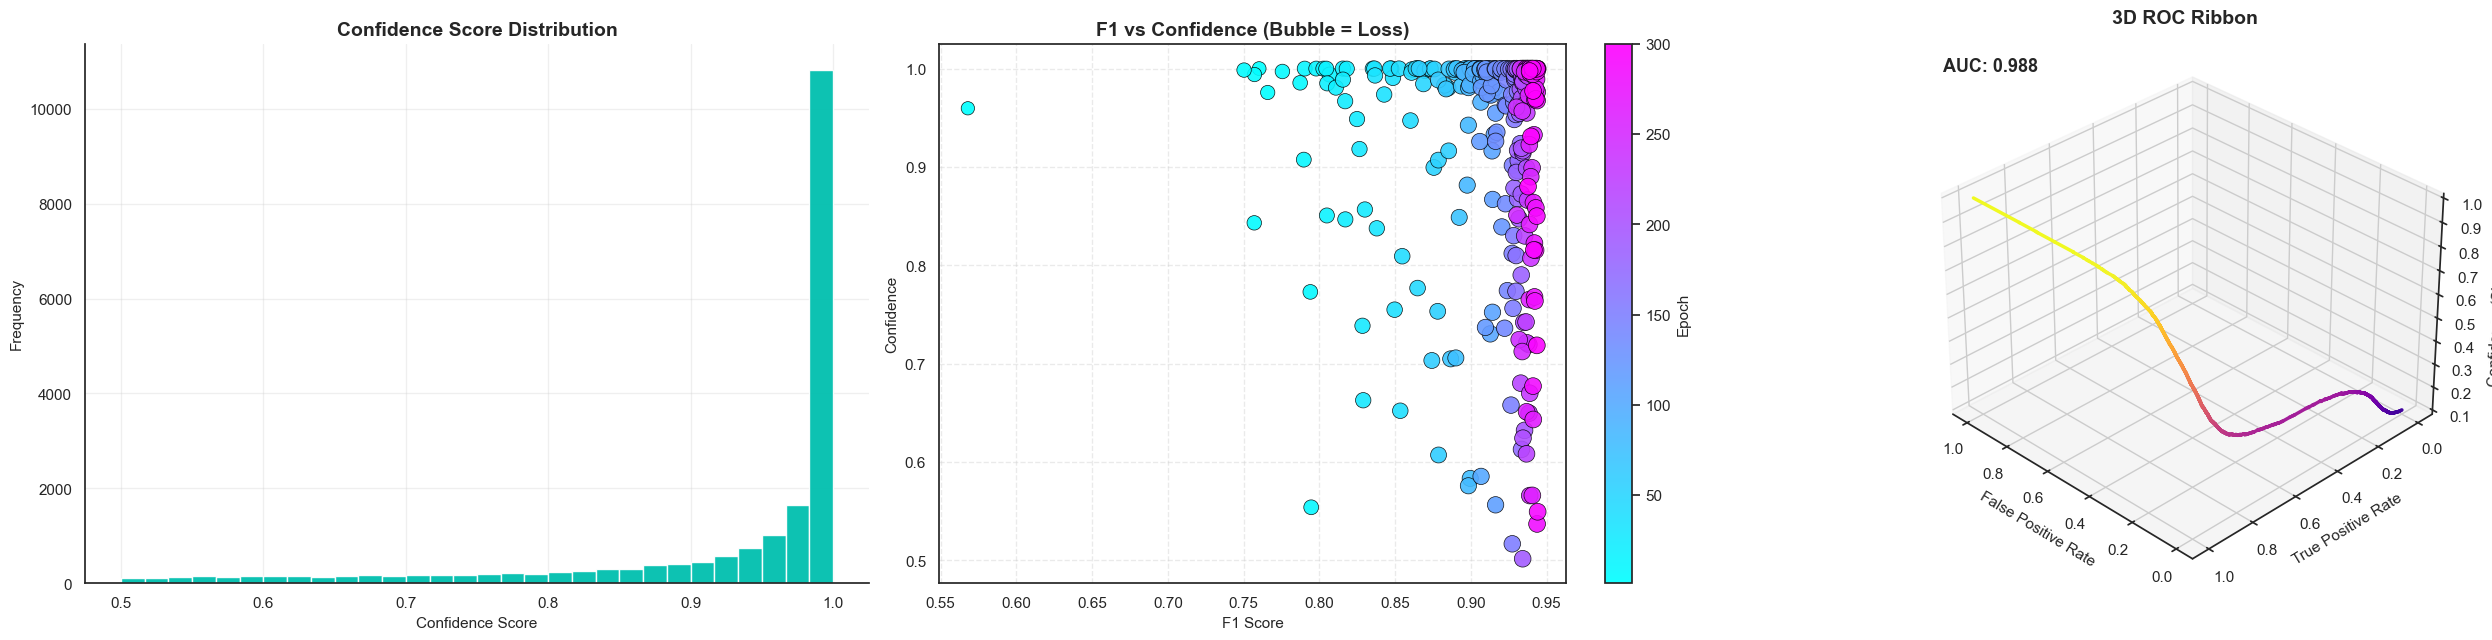

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm, colors
from sklearn.metrics import roc_curve, auc

# Ensure data: confs, f1_vals, conf_vals, epochs, loss_vals, fpr, tpr, roc_auc are already defined

fig = plt.figure(figsize=(26, 18))

# 1️⃣ Confidence Score Distribution (Histogram)
ax7 = fig.add_subplot(337)
ax7.hist(confs, bins=30, color='#00bfae', edgecolor='white', alpha=0.95)
ax7.set_title("Confidence Score Distribution", fontsize=14, weight='bold')
ax7.set_xlabel("Confidence Score")
ax7.set_ylabel("Frequency")
ax7.spines['top'].set_visible(False)
ax7.spines['right'].set_visible(False)
ax7.grid(alpha=0.3)

# 2️⃣ F1 Score vs Confidence Scatter (Bubble = Loss)
ax8 = fig.add_subplot(338)
scatter = ax8.scatter(
    f1_vals,
    conf_vals[:len(f1_vals)],
    c=epochs,
    cmap='cool',
    s=60 + 100 * (1 - np.array(loss_vals)),
    edgecolors='black',
    linewidths=0.5,
    alpha=0.9
)
ax8.set_title("F1 vs Confidence (Bubble = Loss)", fontsize=14, weight='bold')
ax8.set_xlabel("F1 Score")
ax8.set_ylabel("Confidence")
fig.colorbar(scatter, ax=ax8, label='Epoch')
ax8.grid(True, linestyle='--', alpha=0.4)

# 3️⃣ 3D ROC Curve with AUC (Ribbon)
ax9 = fig.add_subplot(339, projection='3d')
z_vals = np.linspace(0.1, 1.0, len(fpr))
norm = colors.Normalize(vmin=0, vmax=1)
cmap = plt.colormaps.get_cmap('plasma')  # ✅ Updated get_cmap syntax

for i in range(len(fpr)-1):
    ax9.plot(
        fpr[i:i+2],
        tpr[i:i+2],
        z_vals[i:i+2],
        color=cmap(norm(z_vals[i])),
        linewidth=2.5
    )

ax9.text2D(0.05, 0.95, f"AUC: {roc_auc:.3f}", transform=ax9.transAxes, fontsize=13, weight='bold')
ax9.set_title("3D ROC Ribbon", fontsize=14, pad=15, weight='bold')
ax9.set_xlabel("False Positive Rate")
ax9.set_ylabel("True Positive Rate")
ax9.set_zlabel("Confidence (Simulated)")
ax9.view_init(elev=32, azim=135)

# Finalize
plt.tight_layout()
plt.savefig("stylish_training_dashboard.png", dpi=350, bbox_inches='tight')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# --- Training metrics (already computed in your code) ---
epochs = np.arange(1, len(loss_history) + 1)
loss_vals = np.array(loss_history)
acc_vals  = np.array(val_acc_history)
f1_vals   = np.array(f1_history)

# ---------- Create interpolation grids (same as before) ----------
grid_x, grid_y = np.meshgrid(
    np.linspace(epochs.min(), epochs.max(), 100),
    np.linspace(acc_vals.min(), acc_vals.max(), 100)
)
grid_loss = griddata((epochs, acc_vals), loss_vals, (grid_x, grid_y), method="cubic")

grid_x2, grid_y2 = np.meshgrid(
    np.linspace(epochs.min(), epochs.max(), 100),
    np.linspace(f1_vals.min(), f1_vals.max(), 100)
)
grid_acc = griddata((epochs, f1_vals), acc_vals, (grid_x2, grid_y2), method="cubic")

grid_x3, grid_y3 = np.meshgrid(
    np.linspace(acc_vals.min(), acc_vals.max(), 100),
    np.linspace(f1_vals.min(), f1_vals.max(), 100)
)
grid_epoch = griddata((acc_vals, f1_vals), epochs, (grid_x3, grid_y3), method="cubic")

# Common style
plt.rcParams.update({
    "font.size": 11,
    "axes.labelsize": 11,
    "axes.titlesize": 12
})

# ---------- Figure 10(a): Epoch vs Accuracy vs Loss ----------
fig1 = plt.figure(figsize=(6, 4.5))
ax1 = fig1.add_subplot(111, projection="3d")
surf1 = ax1.plot_surface(grid_x, grid_y, grid_loss,
                         cmap="viridis", edgecolor="none", alpha=0.9)
ax1.set_title("Epoch vs Accuracy vs Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
ax1.set_zlabel("Loss")

fig1.tight_layout()
fig1.savefig("Figure10a_Epoch_Accuracy_Loss.png", dpi=600, bbox_inches="tight")
plt.close(fig1)

# ---------- Figure 10(b): Epoch vs F1 Score vs Accuracy ----------
fig2 = plt.figure(figsize=(6, 4.5))
ax2 = fig2.add_subplot(111, projection="3d")
surf2 = ax2.plot_surface(grid_x2, grid_y2, grid_acc,
                         cmap="plasma", edgecolor="none", alpha=0.9)
ax2.set_title("Epoch vs F1 Score vs Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1 Score")
ax2.set_zlabel("Accuracy")

fig2.tight_layout()
fig2.savefig("Figure10b_Epoch_F1_Accuracy.png", dpi=600, bbox_inches="tight")
plt.close(fig2)

# ---------- Figure 10(c): Accuracy vs F1 Score vs Epoch ----------
fig3 = plt.figure(figsize=(6, 4.5))
ax3 = fig3.add_subplot(111, projection="3d")
surf3 = ax3.plot_surface(grid_x3, grid_y3, grid_epoch,
                         cmap="cool", edgecolor="none", alpha=0.9)
ax3.set_title("Accuracy vs F1 Score vs Epoch")
ax3.set_xlabel("Accuracy")
ax3.set_ylabel("F1 Score")
ax3.set_zlabel("Epoch")

fig3.tight_layout()
fig3.savefig("Figure10c_Accuracy_F1_Epoch.png", dpi=600, bbox_inches="tight")
plt.close(fig3)

In [ ]:
plt.savefig("3d_metric_surfaces.png", dpi=600, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

In [ ]:
sensor_input = np.array([[54, 22, 70, 21, 19.52, 55.04, 202.93]])
sensor_input = np.concatenate([
    sensor_input,
    [[54*22, 202.93*55.04, np.mean([54]*5), np.mean([22]*5)]]
], axis=1)

sensor_input_scaled = scaler.transform(sensor_input)
sensor_input_fuzzy = fuzzy_transformer.transform(sensor_input_scaled)
sensor_input_pca = pca.transform(sensor_input_fuzzy)

sensor_tensor = torch.tensor(sensor_input_pca, dtype=torch.float32).to(device)

with torch.no_grad():
    output = model(sensor_tensor)
    probs = torch.softmax(output, dim=1)
    prediction = output.argmax(1).item()
    confidence = probs[0][prediction].item()

print(f"Pump Prediction ➤ {'ON' if prediction == 1 else 'OFF'}")
print(f"Confidence Score ➤ {confidence:.4f}")

Pump Prediction ➤ ON
Confidence Score ➤ 1.0000


FUZZY

In [ ]:
# ------------------ Fuzzy-Only Model ------------------
import torch
import torch.nn as nn
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, roc_auc_score
import numpy as np

# ---------- Fuzzy Transformer ----------
class FuzzyTransformer:
    def __init__(self, n_clusters=5):
        self.n_clusters = n_clusters
        self.centers_ = []

    def fit(self, X):
        for i in range(X.shape[1]):
            kmeans = KMeans(n_clusters=self.n_clusters, random_state=42).fit(X[:, i].reshape(-1, 1))
            self.centers_.append(np.sort(kmeans.cluster_centers_.flatten()))
        return self

    def transform(self, X):
        sigma_sq = 2 * (0.1 ** 2)
        fuzzy_feats = [np.exp(-((X[:, i][:, None] - self.centers_[i]) ** 2) / sigma_sq) for i in range(X.shape[1])]
        return np.concatenate(fuzzy_feats, axis=1)

# ---------- Apply Fuzzy Encoding ----------
fuzzy_transformer = FuzzyTransformer(n_clusters=3)
X_train_fuzzy = fuzzy_transformer.fit(X_train).transform(X_train)
X_test_fuzzy = fuzzy_transformer.transform(X_test)

# ---------- Convert to PyTorch ----------
X_train_tensor = torch.tensor(X_train_fuzzy, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_fuzzy, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# ---------- Basic MLP Classifier ----------
class FuzzyMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=2):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        return self.fc2(x)

model = FuzzyMLP(input_dim=X_train_tensor.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)

# ---------- Training ----------
best_acc, patience, trigger = 0, 10, 0
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    out = model(X_train_tensor)
    loss = criterion(out, y_train_tensor)
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        logits = model(X_test_tensor)
        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)
        acc = accuracy_score(y_test_tensor.cpu(), preds.cpu())
        f1_val = f1_score(y_test_tensor.cpu(), preds.cpu())

    if acc > best_acc:
        best_acc = acc
        trigger = 0
        torch.save(model.state_dict(), "fuzzy_model.pt")
    else:
        trigger += 1
    if trigger >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

    print(f"Epoch {epoch+1} - Loss: {loss.item():.4f} - Acc: {acc:.4f} - F1: {f1_val:.4f}")

# ---------- Evaluation ----------
model.load_state_dict(torch.load("fuzzy_model.pt"))
model.eval()
with torch.no_grad():
    logits = model(X_test_tensor)
    probs = torch.softmax(logits, dim=1)
    y_pred = torch.argmax(probs, dim=1).cpu().numpy()
    y_true = y_test_tensor.cpu().numpy()
    confs = torch.max(probs, dim=1).values.cpu().numpy()

# ---------- Metrics ----------
acc = accuracy_score(y_true, y_pred)
f1_final = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
specificity = recall_score(y_true, y_pred, pos_label=0)
auc_score = roc_auc_score(y_true, probs[:, 1].cpu().numpy())
avg_conf = np.mean(confs)
class_0_conf = np.mean(confs[y_pred == 0])
class_1_conf = np.mean(confs[y_pred == 1])
cm = confusion_matrix(y_true, y_pred)

print(f"\n✅ FUZZY MODEL EVALUATION REPORT")
print(f"Accuracy       : {acc*100:.2f}%")
print(f"F1 Score       : {f1_final:.4f}")
print(f"Precision      : {precision:.4f}")
print(f"Recall         : {recall:.4f}")
print(f"Specificity    : {specificity:.4f}")
print(f"AUC-ROC        : {auc_score:.4f}")
print(f"Avg Confidence : {avg_conf:.4f}")
print(f"Conf (OFF)     : {class_0_conf:.4f}")
print(f"Conf (ON)      : {class_1_conf:.4f}")
print(f"Confusion Matrix:\n{cm}")
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=['OFF', 'ON']))

acc_fuzzy = acc
f1_fuzzy = f1_final
precision_fuzzy = precision
recall_fuzzy = recall
specificity_fuzzy = specificity
auc_fuzzy = auc_score
avg_conf_fuzzy = avg_conf

Epoch 1 - Loss: 0.6956 - Acc: 0.6395 - F1: 0.6212
Epoch 2 - Loss: 0.6715 - Acc: 0.6403 - F1: 0.5561
Epoch 3 - Loss: 0.6530 - Acc: 0.6803 - F1: 0.6503
Epoch 4 - Loss: 0.6326 - Acc: 0.7053 - F1: 0.7213
Epoch 5 - Loss: 0.6121 - Acc: 0.7073 - F1: 0.7403
Epoch 6 - Loss: 0.5951 - Acc: 0.7093 - F1: 0.7364
Epoch 7 - Loss: 0.5783 - Acc: 0.7118 - F1: 0.7209
Epoch 8 - Loss: 0.5648 - Acc: 0.7152 - F1: 0.7235
Epoch 9 - Loss: 0.5549 - Acc: 0.7174 - F1: 0.7390
Epoch 10 - Loss: 0.5471 - Acc: 0.7222 - F1: 0.7415
Epoch 11 - Loss: 0.5407 - Acc: 0.7275 - F1: 0.7360
Epoch 12 - Loss: 0.5364 - Acc: 0.7292 - F1: 0.7433
Epoch 13 - Loss: 0.5320 - Acc: 0.7297 - F1: 0.7497
Epoch 14 - Loss: 0.5302 - Acc: 0.7333 - F1: 0.7453
Epoch 15 - Loss: 0.5280 - Acc: 0.7341 - F1: 0.7451
Epoch 16 - Loss: 0.5270 - Acc: 0.7355 - F1: 0.7535
Epoch 17 - Loss: 0.5259 - Acc: 0.7366 - F1: 0.7524
Epoch 18 - Loss: 0.5243 - Acc: 0.7380 - F1: 0.7483
Epoch 19 - Loss: 0.5230 - Acc: 0.7378 - F1: 0.7520
Epoch 20 - Loss: 0.5205 - Acc: 0.7380 - 

C:\Users\HCI_Lab\AppData\Local\Temp\ipykernel_4948\3229560516.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("fuzzy_model.pt"))


SNN

In [ ]:
# ------------------ SNN-Only Model ------------------
import snntorch as snn
import snntorch.functional as SF
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, roc_auc_score
import numpy as np

# ---------- SNN Architecture ----------
class SNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=2):
        super().__init__()
        beta = 0.95
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        cur1 = self.fc1(x)
        spk1, mem1 = self.lif1(cur1, mem1)
        out = self.fc2(spk1)
        return out

# ---------- Tensor Conversion ----------
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# ---------- Model Init ----------
model = SNNModel(input_dim=X_train_tensor.shape[1], hidden_dim=64, output_dim=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)

# ---------- Training ----------
best_acc, patience, trigger = 0, 10, 0
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    out = model(X_train_tensor)
    loss = criterion(out, y_train_tensor)
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        logits = model(X_test_tensor)
        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)
        acc = accuracy_score(y_test_tensor.cpu(), preds.cpu())
        f1_val = f1_score(y_test_tensor.cpu(), preds.cpu())

    if acc > best_acc:
        best_acc = acc
        trigger = 0
        torch.save(model.state_dict(), "snn_model_only.pt")
    else:
        trigger += 1
    if trigger >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

    print(f"Epoch {epoch+1} - Loss: {loss.item():.4f} - Acc: {acc:.4f} - F1: {f1_val:.4f}")

# ---------- Evaluation ----------
model.load_state_dict(torch.load("snn_model_only.pt"))
model.eval()
with torch.no_grad():
    logits = model(X_test_tensor)
    probs = torch.softmax(logits, dim=1)
    y_pred = torch.argmax(probs, dim=1).cpu().numpy()
    y_true = y_test_tensor.cpu().numpy()
    confs = torch.max(probs, dim=1).values.cpu().numpy()

# ---------- Metrics ----------
acc = accuracy_score(y_true, y_pred)
f1_final = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
specificity = recall_score(y_true, y_pred, pos_label=0)
auc_score = roc_auc_score(y_true, probs[:, 1].cpu().numpy())
avg_conf = np.mean(confs)
class_0_conf = np.mean(confs[y_pred == 0])
class_1_conf = np.mean(confs[y_pred == 1])
cm = confusion_matrix(y_true, y_pred)

print(f"\n✅ SNN-ONLY MODEL EVALUATION REPORT")
print(f"Accuracy       : {acc*100:.2f}%")
print(f"F1 Score       : {f1_final:.4f}")
print(f"Precision      : {precision:.4f}")
print(f"Recall         : {recall:.4f}")
print(f"Specificity    : {specificity:.4f}")
print(f"AUC-ROC        : {auc_score:.4f}")
print(f"Avg Confidence : {avg_conf:.4f}")
print(f"Conf (OFF)     : {class_0_conf:.4f}")
print(f"Conf (ON)      : {class_1_conf:.4f}")
print(f"Confusion Matrix:\n{cm}")
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=['OFF', 'ON']))

acc_snn = acc
f1_snn = f1_final
precision_snn = precision
recall_snn = recall
specificity_snn = specificity
auc_snn = auc_score
avg_conf_snn = avg_conf

Epoch 1 - Loss: 0.6950 - Acc: 0.4635 - F1: 0.0000
Epoch 2 - Loss: 0.6944 - Acc: 0.4635 - F1: 0.0000
Epoch 3 - Loss: 0.6940 - Acc: 0.4644 - F1: 0.0050
Epoch 4 - Loss: 0.6936 - Acc: 0.4662 - F1: 0.0155
Epoch 5 - Loss: 0.6933 - Acc: 0.4697 - F1: 0.0344
Epoch 6 - Loss: 0.6929 - Acc: 0.4804 - F1: 0.0867
Epoch 7 - Loss: 0.6922 - Acc: 0.5365 - F1: 0.6983
Epoch 8 - Loss: 0.6908 - Acc: 0.5366 - F1: 0.6984
Epoch 9 - Loss: 0.6881 - Acc: 0.5375 - F1: 0.6987
Epoch 10 - Loss: 0.6834 - Acc: 0.5418 - F1: 0.7002
Epoch 11 - Loss: 0.6775 - Acc: 0.5579 - F1: 0.7039
Epoch 12 - Loss: 0.6713 - Acc: 0.5922 - F1: 0.7157
Epoch 13 - Loss: 0.6623 - Acc: 0.6357 - F1: 0.7277
Epoch 14 - Loss: 0.6514 - Acc: 0.6644 - F1: 0.7270
Epoch 15 - Loss: 0.6412 - Acc: 0.6411 - F1: 0.6227
Epoch 16 - Loss: 0.6314 - Acc: 0.6501 - F1: 0.6273
Epoch 17 - Loss: 0.6213 - Acc: 0.6585 - F1: 0.6373
Epoch 18 - Loss: 0.6092 - Acc: 0.6688 - F1: 0.6554
Epoch 19 - Loss: 0.5953 - Acc: 0.6739 - F1: 0.6678
Epoch 20 - Loss: 0.5834 - Acc: 0.6757 - 

C:\Users\HCI_Lab\AppData\Local\Temp\ipykernel_4948\862367147.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("snn_model_only.pt"))


PSO optimized logistic regrssion

In [ ]:
# ------------------ PSO-Only Model (Optimizing Logistic Regression) ------------------
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report, roc_auc_score
from pyswarms.single.global_best import GlobalBestPSO
from sklearn.model_selection import cross_val_score
import numpy as np

# ------------------ Objective Function ------------------
def objective_function(params):
    """PSO Objective: Negative cross-validated accuracy for Logistic Regression"""
    scores = []
    for c in params:
        lr = LogisticRegression(C=c[0], max_iter=300, solver='lbfgs')
        acc = cross_val_score(lr, X_train, y_train, cv=3, scoring='accuracy').mean()
        scores.append(-acc)  # Minimize negative accuracy
    return np.array(scores)

# ------------------ PSO Setup ------------------
# Bounds for C (regularization parameter)
bounds = ([0.0001], [10.0])  # Lower and upper bounds
optimizer = GlobalBestPSO(n_particles=10, dimensions=1, options={'c1': 0.6, 'c2': 0.3, 'w': 0.7}, bounds=bounds)

# Run PSO
best_cost, best_pos = optimizer.optimize(objective_function, iters=20)
best_c = best_pos[0]
print(f"\n🌀 Best C found by PSO: {best_c:.4f}")

# ------------------ Train Final Logistic Regression ------------------
pso_model = LogisticRegression(C=best_c, max_iter=300, solver='lbfgs')
pso_model.fit(X_train, y_train)

# ------------------ Predictions and Evaluation ------------------
y_pred = pso_model.predict(X_test)
y_proba = pso_model.predict_proba(X_test)[:, 1]
confs = np.max(pso_model.predict_proba(X_test), axis=1)

# Metrics
acc = accuracy_score(y_test, y_pred)
f1_final = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
specificity = recall_score(y_test, y_pred, pos_label=0)
auc_score = roc_auc_score(y_test, y_proba)
avg_conf = np.mean(confs)
class_0_conf = np.mean(confs[y_pred == 0])
class_1_conf = np.mean(confs[y_pred == 1])
cm = confusion_matrix(y_test, y_pred)

# Print Report
print(f"\n✅ PSO-LOGISTIC MODEL EVALUATION REPORT")
print(f"Accuracy       : {acc*100:.2f}%")
print(f"F1 Score       : {f1_final:.4f}")
print(f"Precision      : {precision:.4f}")
print(f"Recall         : {recall:.4f}")
print(f"Specificity    : {specificity:.4f}")
print(f"AUC-ROC        : {auc_score:.4f}")
print(f"Avg Confidence : {avg_conf:.4f}")
print(f"Conf (OFF)     : {class_0_conf:.4f}")
print(f"Conf (ON)      : {class_1_conf:.4f}")
print(f"Confusion Matrix:\n{cm}")
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=['OFF', 'ON']))

acc_pso = acc
f1_pso = f1_final
precision_pso = precision
recall_pso = recall
specificity_pso = specificity
auc_pso = auc_score
avg_conf_pso = avg_conf

2025-12-10 13:55:31,403 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.6, 'c2': 0.3, 'w': 0.7}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=-0.725
2025-12-10 13:55:52,951 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.7249250155392333, best pos: [9.29619844]



🌀 Best C found by PSO: 9.2962

✅ PSO-LOGISTIC MODEL EVALUATION REPORT
Accuracy       : 72.65%
F1 Score       : 0.7506
Precision      : 0.7348
Recall         : 0.7671
Specificity    : 0.6795
AUC-ROC        : 0.8000
Avg Confidence : 0.7279
Conf (OFF)     : 0.7209
Conf (ON)      : 0.7333
Confusion Matrix:
[[6299 2971]
 [2499 8231]]

Classification Report:
               precision    recall  f1-score   support

         OFF       0.72      0.68      0.70      9270
          ON       0.73      0.77      0.75     10730

    accuracy                           0.73     20000
   macro avg       0.73      0.72      0.72     20000
weighted avg       0.73      0.73      0.73     20000



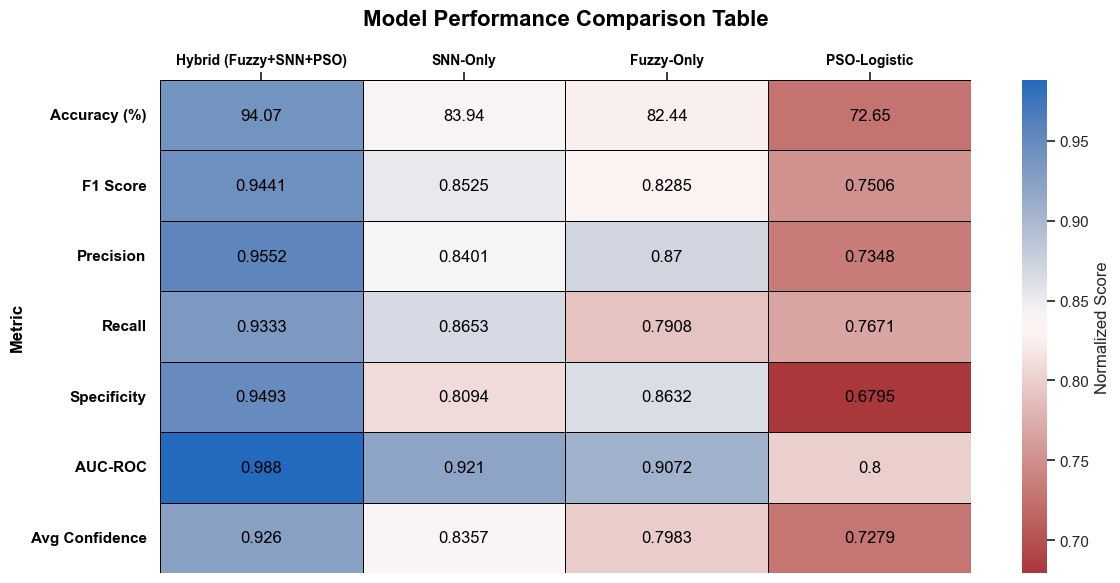

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ----------- Data Dictionary -----------
data = {
    "Model": ["Hybrid (Fuzzy+SNN+PSO)", "SNN-Only", "Fuzzy-Only", "PSO-Logistic"],
    "Accuracy (%)": [acc_hybrid * 100, acc_snn * 100, acc_fuzzy * 100, acc_pso * 100],
    "F1 Score": [f1_hybrid, f1_snn, f1_fuzzy, f1_pso],
    "Precision": [precision_hybrid, precision_snn, precision_fuzzy, precision_pso],
    "Recall": [recall_hybrid, recall_snn, recall_fuzzy, recall_pso],
    "Specificity": [specificity_hybrid, specificity_snn, specificity_fuzzy, specificity_pso],
    "AUC-ROC": [auc_hybrid, auc_snn, auc_fuzzy, auc_pso],
    "Avg Confidence": [avg_conf_hybrid, avg_conf_snn, avg_conf_fuzzy, avg_conf_pso],
}

# ----------- DataFrames: Real & Normalized -----------
df = pd.DataFrame(data).set_index("Model").T.round(4)
df_normalized = df.copy()
df_normalized.loc["Accuracy (%)"] = df.loc["Accuracy (%)"] / 100

# ----------- Plotting with full-spectrum vlag_r colormap -----------
plt.figure(figsize=(12, 6))
sns.set_theme(style="white")

ax = sns.heatmap(
    df_normalized,
    annot=df,
    fmt=".4g",
    cmap="vlag_r",                 # ✅ Reversed and saturated vlag
    linewidths=0.5,
    linecolor="black",
    cbar_kws={"label": "Normalized Score"},
    annot_kws={"fontsize": 12, "color": "black"}  # Clean black values
)

# ----------- Axis Labels -----------
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.xticks(rotation=0, fontsize=10, weight='bold', color='black')
plt.yticks(rotation=0, fontsize=11, weight='bold', color='black')
plt.title("Model Performance Comparison Table", fontsize=16, pad=20, weight='bold', color='black')
plt.xlabel("")
plt.ylabel("Metric", fontsize=12, weight='bold', color='black')

# ----------- Finalize -----------
plt.tight_layout()
plt.savefig("vlag_r_saturated_heatmap1.png", dpi=300)
plt.show()

C:\Users\HCI_Lab\AppData\Local\Temp\ipykernel_4948\2066689533.py:93: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  plt.savefig("3D_accuracy_confidence_final1.png", dpi=300)


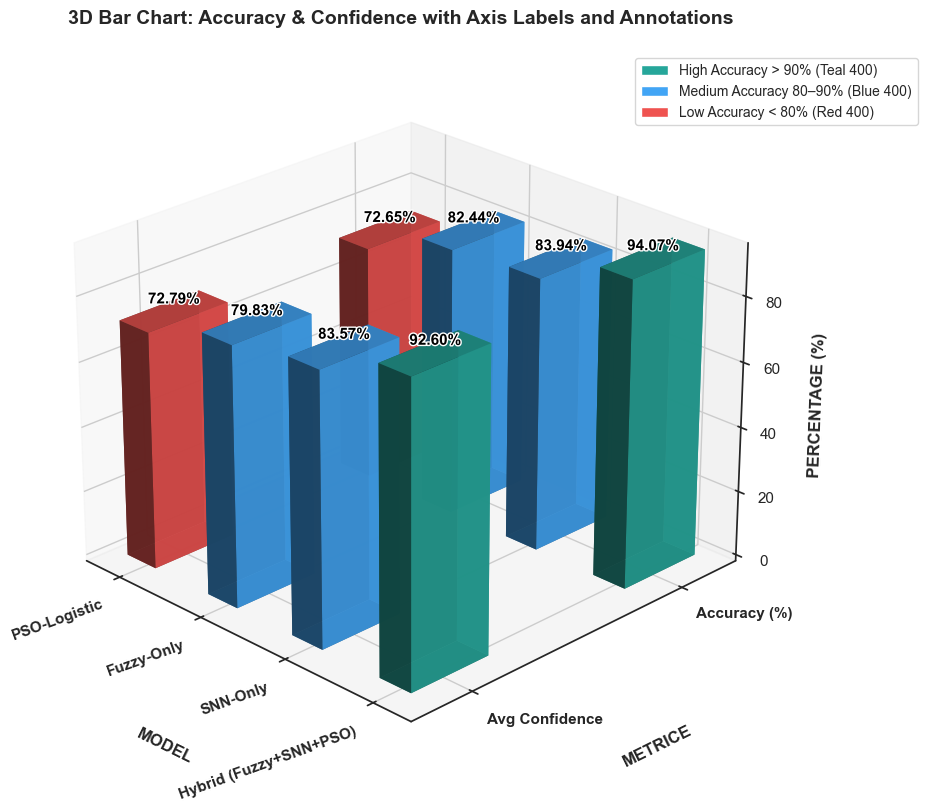

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Patch
import matplotlib.patheffects as path_effects

# ----------- Data Dictionary (You already have these values computed) -----------
data = {
    "Model": ["Hybrid (Fuzzy+SNN+PSO)", "SNN-Only", "Fuzzy-Only", "PSO-Logistic"],
    "Accuracy (%)": [acc_hybrid * 100, acc_snn * 100, acc_fuzzy * 100, acc_pso * 100],
    "Avg Confidence": [avg_conf_hybrid * 100, avg_conf_snn * 100, avg_conf_fuzzy * 100, avg_conf_pso * 100],
}

# ----------- DataFrames: Real & Normalized -----------
df_raw = pd.DataFrame(data)
df = df_raw.set_index("Model").T.round(2)
df_normalized = df.copy()
df_normalized.loc["Accuracy (%)"] = df.loc["Accuracy (%)"] / 100

# ----------- Setup -----------
fig = plt.figure(figsize=(14, 8), constrained_layout=True)
ax = fig.add_subplot(111, projection='3d')

x_labels = df.columns.tolist()
y_labels = df.index.tolist()

x_pos = np.arange(len(x_labels))
y_pos = np.arange(len(y_labels))
dx = dy = 0.35

# ----------- Color Function -----------
def get_light_color(value):
    if value > 90:
        return '#26A69A'  # Teal 400
    elif value >= 80:
        return '#42A5F5'  # Blue 400
    else:
        return '#EF5350'  # Red 400

# ----------- Plot Bars + Annotate -----------
for i, x_label in enumerate(x_labels):
    for j, y_label in enumerate(y_labels):
        z_val = df.loc[y_label, x_label]
        acc_val = df.loc["Accuracy (%)", x_label]
        color = get_light_color(acc_val)
        x = x_pos[i]
        y = y_pos[j]
        ax.bar3d(x, y, 0, dx, dy, z_val, color=color, alpha=0.9, edgecolor='none')

        # Text on top of bars
        label = ax.text(
            x + dx/2,
            y + dy/2,
            z_val + 1.5,
            f"{z_val:.2f}%",
            ha='center',
            va='bottom',
            fontsize=11,
            weight='bold',
            color='black',
            zorder=10,
            clip_on=False
        )
        label.set_path_effects([
            path_effects.withStroke(linewidth=2, foreground='white')
        ])


# ----------- Axis Ticks and Labels -----------
ax.set_xticks(x_pos + dx / 2)
ax.set_xticklabels(x_labels, rotation=20, ha='right', fontsize=11, weight='bold')

ax.set_yticks(y_pos + dy / 2)
ax.set_yticklabels(y_labels, ha='left', fontsize=11, weight='bold')
ax.set_zlabel("PERCENTAGE (%)", fontsize=12, weight='bold', labelpad=10)
ax.set_xlabel("MODEL", fontsize=12, weight='bold', labelpad=40)
ax.set_ylabel("METRICE", fontsize=12, weight='bold', labelpad=40)
ax.set_title("3D Bar Chart: Accuracy & Confidence with Axis Labels and Annotations", pad=20, fontsize=14, weight='bold')

# ----------- View Angle -----------
ax.view_init(elev=25, azim=135)

# ----------- Legend -----------
legend_elements = [
    Patch(facecolor='#26A69A', label='High Accuracy > 90% (Teal 400)'),
    Patch(facecolor='#42A5F5', label='Medium Accuracy 80–90% (Blue 400)'),
    Patch(facecolor='#EF5350', label='Low Accuracy < 80% (Red 400)'),
]
ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.22, 1), fontsize=10)

# ----------- Save & Show -----------
plt.savefig("3D_accuracy_confidence_final1.png", dpi=300)
plt.show()

In [ ]:
# %%
!pip install xgboost

In [ ]:
# %% [markdown]
# Classic ML baselines: Random Forest, XGBoost, SVM (RBF)

# %%
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, classification_report, roc_auc_score
)
import numpy as np

def evaluate_sklearn_model(name, model, X_train, y_train, X_test, y_test):
    """Fit model, compute metrics, return dict of scores."""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # probability-based scores (if available)
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_test)
        y_score = proba[:, 1]
        confs = proba.max(axis=1)
    else:
        # for SVM if probability=False (but we will set probability=True anyway)
        y_score = None
        confs = np.ones_like(y_pred, dtype=float)

    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall    = recall_score(y_test, y_pred)
    specificity = recall_score(y_test, y_pred, pos_label=0)
    auc = roc_auc_score(y_test, y_score) if y_score is not None else np.nan
    avg_conf = confs.mean()

    print(f"\n✅ {name} MODEL EVALUATION REPORT")
    print(f"Accuracy       : {acc*100:.2f}%")
    print(f"F1 Score       : {f1:.4f}")
    print(f"Precision      : {precision:.4f}")
    print(f"Recall         : {recall:.4f}")
    print(f"Specificity    : {specificity:.4f}")
    print(f"AUC-ROC        : {auc:.4f}")
    print(f"Avg Confidence : {avg_conf:.4f}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")
    print("\nClassification Report:\n",
          classification_report(y_test, y_pred, target_names=['OFF', 'ON']))

    return {
        "acc": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "specificity": specificity,
        "auc": auc,
        "avg_conf": avg_conf,
    }

# ---------- Random Forest ----------
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=SEED,
    class_weight="balanced"
)
rf_scores = evaluate_sklearn_model("Random Forest", rf_model, X_train, y_train, X_test, y_test)

# ---------- XGBoost ----------
xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=SEED
)
xgb_scores = evaluate_sklearn_model("XGBoost", xgb_model, X_train, y_train, X_test, y_test)

# ---------- SVM (RBF kernel) ----------
svm_model = SVC(
    kernel="rbf",
    C=5.0,
    gamma="scale",
    probability=True,   # so we can use predict_proba
    class_weight="balanced",
    random_state=SEED
)
svm_scores = evaluate_sklearn_model("SVM (RBF)", svm_model, X_train, y_train, X_test, y_test)

# store for plotting
acc_rf, f1_rf, precision_rf, recall_rf, specificity_rf, auc_rf, avg_conf_rf = (
    rf_scores["acc"], rf_scores["f1"], rf_scores["precision"], rf_scores["recall"],
    rf_scores["specificity"], rf_scores["auc"], rf_scores["avg_conf"]
)

acc_xgb, f1_xgb, precision_xgb, recall_xgb, specificity_xgb, auc_xgb, avg_conf_xgb = (
    xgb_scores["acc"], xgb_scores["f1"], xgb_scores["precision"], xgb_scores["recall"],
    xgb_scores["specificity"], xgb_scores["auc"], xgb_scores["avg_conf"]
)

acc_svm, f1_svm, precision_svm, recall_svm, specificity_svm, auc_svm, avg_conf_svm = (
    svm_scores["acc"], svm_scores["f1"], svm_scores["precision"], svm_scores["recall"],
    svm_scores["specificity"], svm_scores["auc"], svm_scores["avg_conf"]
)



✅ Random Forest MODEL EVALUATION REPORT
Accuracy       : 99.44%
F1 Score       : 0.9947
Precision      : 0.9929
Recall         : 0.9966
Specificity    : 0.9918
AUC-ROC        : 0.9999
Avg Confidence : 0.9527
Confusion Matrix:
[[ 9194    76]
 [   37 10693]]

Classification Report:
               precision    recall  f1-score   support

         OFF       1.00      0.99      0.99      9270
          ON       0.99      1.00      0.99     10730

    accuracy                           0.99     20000
   macro avg       0.99      0.99      0.99     20000
weighted avg       0.99      0.99      0.99     20000


✅ XGBoost MODEL EVALUATION REPORT
Accuracy       : 99.06%
F1 Score       : 0.9913
Precision      : 0.9868
Recall         : 0.9958
Specificity    : 0.9846
AUC-ROC        : 0.9997
Avg Confidence : 0.9564
Confusion Matrix:
[[ 9127   143]
 [   45 10685]]

Classification Report:
               precision    recall  f1-score   support

         OFF       1.00      0.98      0.99      9270
    

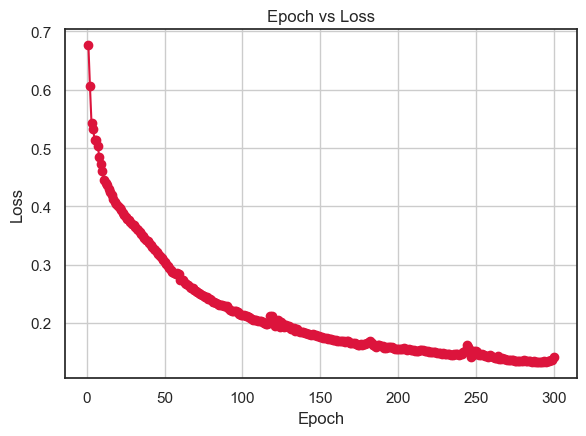

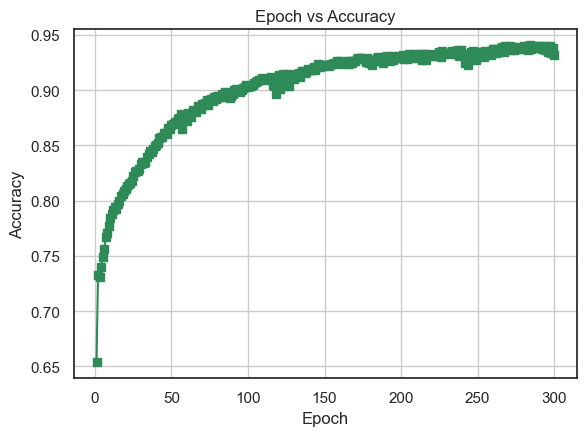

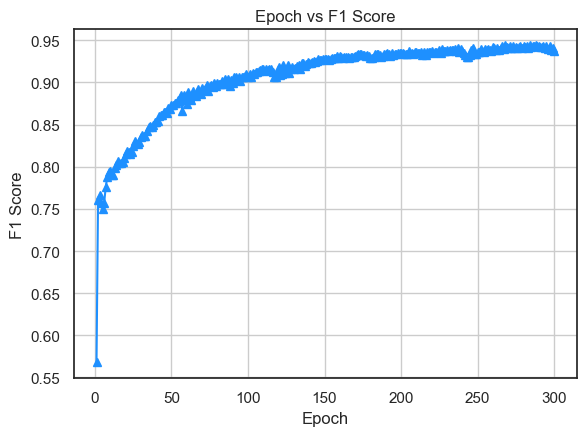

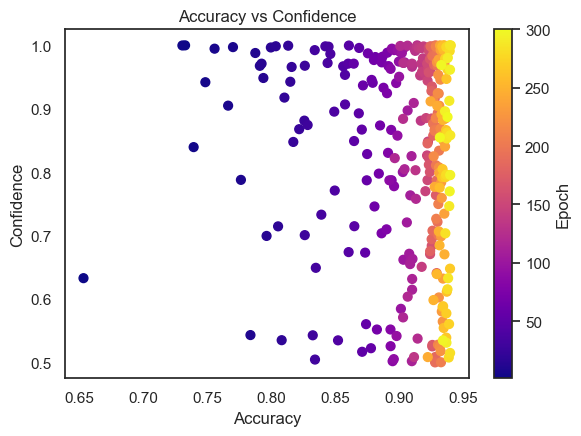

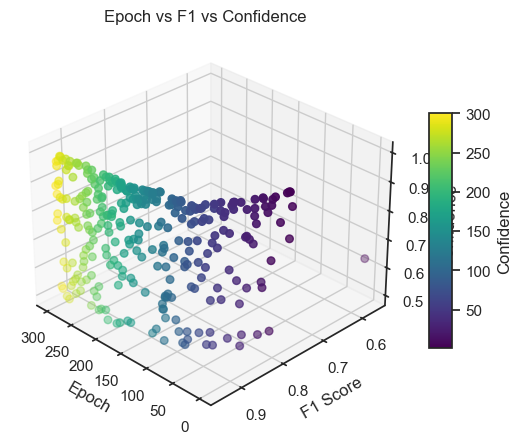

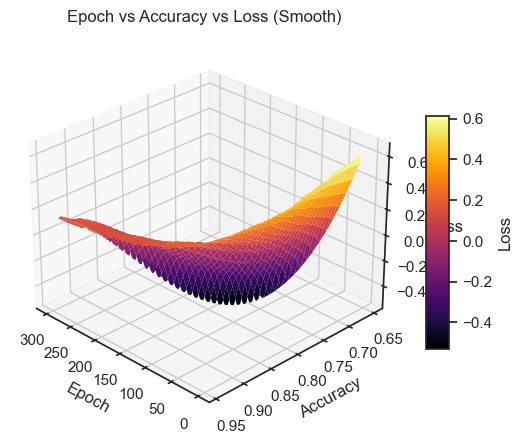

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from matplotlib import cm
from scipy.interpolate import griddata
import torch

# ------------------ Load / align data ------------------
min_len = min(len(loss_history), len(val_acc_history), len(f1_history))
epochs   = np.arange(1, min_len + 1)
loss_vals = np.array(loss_history[:min_len])
acc_vals  = np.array(val_acc_history[:min_len])
f1_vals   = np.array(f1_history[:min_len])

# ----- confidence_history from evaluation -----
confidence_history = []
with torch.no_grad():
    for i in range(len(X_test_tensor)):
        prob = torch.softmax(model(X_test_tensor[i].unsqueeze(0)), dim=1)
        confidence = torch.max(prob).item()
        confidence_history.append(confidence)

conf_vals = np.array(confidence_history[:min_len])

plt.rcParams.update({"font.size": 11})

# --------------------------------------------
# 1️⃣ Epoch vs Loss
# --------------------------------------------
plt.figure(figsize=(6, 4.5))
plt.plot(epochs, loss_vals, marker="o", color="crimson")
plt.title("Epoch vs Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.savefig("Figure9a_Epoch_vs_Loss.png", dpi=600)
plt.show()

# --------------------------------------------
# 2️⃣ Epoch vs Accuracy
# --------------------------------------------
plt.figure(figsize=(6, 4.5))
plt.plot(epochs, acc_vals, marker="s", color="seagreen")
plt.title("Epoch vs Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.savefig("Figure9b_Epoch_vs_Accuracy.png", dpi=600)
plt.show()

# --------------------------------------------
# 3️⃣ Epoch vs F1 Score
# --------------------------------------------
plt.figure(figsize=(6, 4.5))
plt.plot(epochs, f1_vals, marker="^", color="dodgerblue")
plt.title("Epoch vs F1 Score")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.grid(True)
plt.tight_layout()
plt.savefig("Figure9c_Epoch_vs_F1.png", dpi=600)
plt.show()

# --------------------------------------------
# 4️⃣ Accuracy vs Confidence
# --------------------------------------------
plt.figure(figsize=(6, 4.5))
sc = plt.scatter(acc_vals, conf_vals, c=epochs, cmap='plasma', s=40)
plt.title("Accuracy vs Confidence")
plt.xlabel("Accuracy")
plt.ylabel("Confidence")
plt.colorbar(sc, label="Epoch")
plt.tight_layout()
plt.savefig("Figure9d_Accuracy_vs_Confidence.png", dpi=600)
plt.show()

# --------------------------------------------
# 5️⃣ 3D Scatter: Epoch vs F1 vs Confidence
# --------------------------------------------
fig = plt.figure(figsize=(6, 4.5))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(epochs, f1_vals, conf_vals,
               c=epochs, cmap='viridis', s=30, depthshade=True)
ax.set_title("Epoch vs F1 vs Confidence", pad=10)
ax.set_xlabel("Epoch")
ax.set_ylabel("F1 Score")
ax.set_zlabel("Confidence")
ax.view_init(elev=30, azim=135)
fig.colorbar(p, ax=ax, shrink=0.6, aspect=10, label="Confidence" \
"" \
"")
plt.tight_layout()
plt.savefig("Figure9e_3D_Epoch_F1_Confidence.png", dpi=600)
plt.show()

# --------------------------------------------
# 6️⃣ 3D Surface — Epoch vs Accuracy vs Loss
# --------------------------------------------
grid_x, grid_y = np.meshgrid(
    np.linspace(epochs.min(), epochs.max(), 100),
    np.linspace(acc_vals.min(), acc_vals.max(), 100)
)

grid_z = griddata(
    (epochs, acc_vals),
    loss_vals,
    (grid_x, grid_y),
    method='cubic'
)

fig = plt.figure(figsize=(6, 4.5))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(grid_x, grid_y, grid_z,
                       cmap=cm.inferno,
                       edgecolor='none',
                       linewidth=0,
                       antialiased=True)
ax.set_title("Epoch vs Accuracy vs Loss (Smooth)", pad=12)
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.set_zlabel("Loss")
ax.view_init(elev=28, azim=135)
fig.colorbar(surf, ax=ax, shrink=0.6, aspect=10, label='Loss')
plt.tight_layout()
plt.savefig("Figure9f_3D_Surface_Epoch_Accuracy_Loss.png", dpi=600)
plt.show()


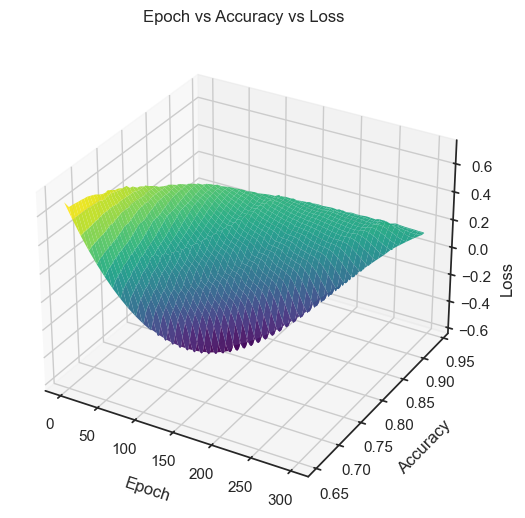

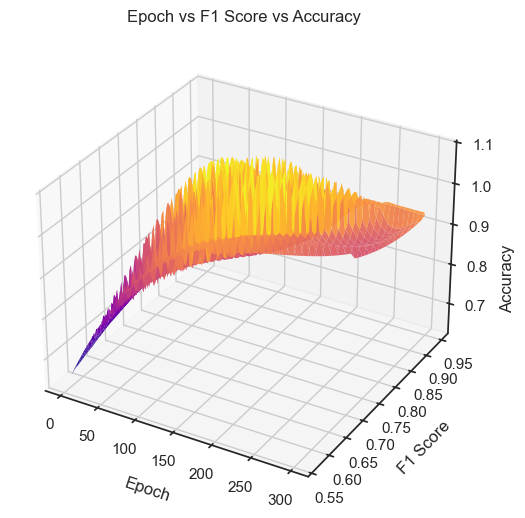

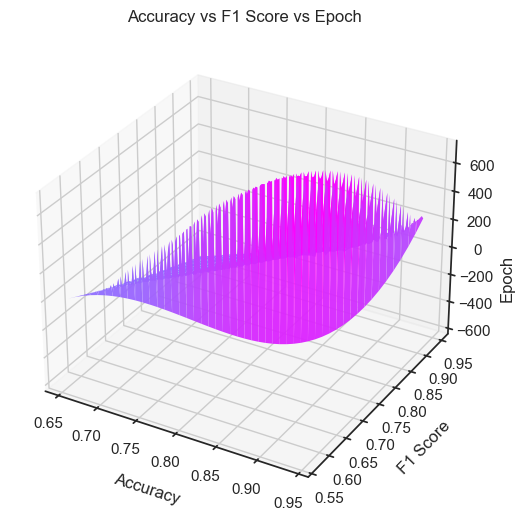

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D

# ============================
# Load Training Metrics
# ============================
epochs    = np.arange(1, len(loss_history) + 1)
loss_vals = np.array(loss_history)
acc_vals  = np.array(val_acc_history)
f1_vals   = np.array(f1_history)

# ============================
# Prepare Interpolation Grids
# ============================

# 1️⃣ Epoch vs Accuracy vs Loss
grid_x, grid_y = np.meshgrid(
    np.linspace(epochs.min(), epochs.max(), 150),
    np.linspace(acc_vals.min(), acc_vals.max(), 150)
)
grid_loss = griddata((epochs, acc_vals), loss_vals, (grid_x, grid_y), method='cubic')

# 2️⃣ Epoch vs F1 vs Accuracy
grid_x2, grid_y2 = np.meshgrid(
    np.linspace(epochs.min(), epochs.max(), 150),
    np.linspace(f1_vals.min(), f1_vals.max(), 150)
)
grid_acc = griddata((epochs, f1_vals), acc_vals, (grid_x2, grid_y2), method='cubic')

# 3️⃣ Accuracy vs F1 vs Epoch
grid_x3, grid_y3 = np.meshgrid(
    np.linspace(acc_vals.min(), acc_vals.max(), 150),
    np.linspace(f1_vals.min(), f1_vals.max(), 150)
)
grid_epoch = griddata((acc_vals, f1_vals), epochs, (grid_x3, grid_y3), method='cubic')


# ============================
# Helper: layout + side z-label
# ============================
def show_and_save(fig, ax, filename, z_side_label: str):
    # Push plot slightly to the right so label can sit close
    fig.subplots_adjust(left=0.12, right=0.90, bottom=0.12, top=0.90)

    # Side label: closer to the axis (0.82–0.84 is near the box)
    fig.text(
        0.83, 0.50, z_side_label,
        va='center', ha='left',
        rotation=90,
        fontsize=12
    )

    fig.savefig(filename, dpi=600, bbox_inches='tight', pad_inches=0.20)
    plt.show()


# ============================
#   FIGURE 10(a): Epoch–Acc–Loss
# ============================
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(grid_x, grid_y, grid_loss,
                cmap='viridis', edgecolor='none', alpha=0.95)

ax.set_title("Epoch vs Accuracy vs Loss", pad=12)
ax.set_xlabel("Epoch", labelpad=8)
ax.set_ylabel("Accuracy", labelpad=8)
ax.set_zlabel("")  # use side label instead

ax.margins(0.05)
show_and_save(fig, ax, "Figure10a_Epoch_Accuracy_Loss.png", "Loss")


# ============================
#   FIGURE 10(b): Epoch–F1–Acc
# ============================
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(grid_x2, grid_y2, grid_acc,
                cmap='plasma', edgecolor='none', alpha=0.95)

ax.set_title("Epoch vs F1 Score vs Accuracy", pad=12)
ax.set_xlabel("Epoch", labelpad=8)
ax.set_ylabel("F1 Score", labelpad=8)
ax.set_zlabel("")

ax.margins(0.05)
show_and_save(fig, ax, "Figure10b_Epoch_F1_Accuracy.png", "Accuracy")


# ============================
#   FIGURE 10(c): Acc–F1–Epoch
# ============================
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(grid_x3, grid_y3, grid_epoch,
                cmap='cool', edgecolor='none', alpha=0.95)

ax.set_title("Accuracy vs F1 Score vs Epoch", pad=12)
ax.set_xlabel("Accuracy", labelpad=8)
ax.set_ylabel("F1 Score", labelpad=8)
ax.set_zlabel("")

ax.margins(0.05)
show_and_save(fig, ax, "Figure10c_Accuracy_F1_Epoch.png", "Epoch")

In [ ]:
data_raw = pd.read_csv("iotsensordata1.csv", encoding="utf-8-sig")

print("Raw columns:", df_raw.columns.tolist())
data_raw.head()

Raw columns: ['soil_moisture_%', 'temperature_°c', 'soil_humidity_%', 'time_hr', 'air_temperature__°c', 'air_humidity__%', 'ph', 'rainfall_mm', 'status']


,Soil Moisture(%),Temperature(°C),Soil Humidity(%),Time(Hr),Air temperature (°C),Air humidity (%),ph,rainfall(mm),Status
0,54,22,70,21,19.52,55.04,6.502985,202.935536,ON
1,12,20,40,104,19.49,55.17,7.038096,226.655537,OFF
2,34,26,35,62,19.47,55.30,7.840207,263.964248,ON
3,7,44,44,93,19.54,54.20,6.980401,242.864034,OFF
4,50,38,23,92,19.61,53.09,7.628473,262.717340,OFF


In [ ]:
data_raw.columns = [
    col.strip().lower().replace("(", "_").replace(")", "_").replace(" ", "_").rstrip("_")
    for col in data_raw.columns
]

print("Cleaned columns:", data_raw.columns.tolist())
data_raw.head()

Cleaned columns: ['soil_moisture_%', 'temperature_°c', 'soil_humidity_%', 'time_hr', 'air_temperature__°c', 'air_humidity__%', 'ph', 'rainfall_mm', 'status']


,soil_moisture_%,temperature_°c,soil_humidity_%,time_hr,air_temperature__°c,air_humidity__%,ph,rainfall_mm,status
0,54,22,70,21,19.52,55.04,6.502985,202.935536,ON
1,12,20,40,104,19.49,55.17,7.038096,226.655537,OFF
2,34,26,35,62,19.47,55.30,7.840207,263.964248,ON
3,7,44,44,93,19.54,54.20,6.980401,242.864034,OFF
4,50,38,23,92,19.61,53.09,7.628473,262.717340,OFF


In [ ]:
data_raw["status"] = data_raw["status"].str.lower().map({"off": 0, "on": 1})

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

X = data_raw.drop(columns=["status"]).values
y = data_raw["status"].values

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss"
)

xgb.fit(X_train_raw, y_train_raw)
y_pred = xgb.predict(X_test_raw)
print("Accuracy:", accuracy_score(y_test_raw, y_pred))

Accuracy: 0.9987


In [ ]:
# ------------------ XGBoost Baseline (Offline Upper Bound) ------------------
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, classification_report, roc_auc_score
)
import numpy as np

# Make sure you are using the SAME X_train, X_test, y_train, y_test
# as defined earlier (with feature engineering + MinMaxScaler)

xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=SEED,
    n_jobs=-1,
)

# Fit and predict
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]
confs_xgb = np.max(xgb_model.predict_proba(X_test), axis=1)

# Metrics (same style as hybrid)
acc_xgb        = accuracy_score(y_test, y_pred_xgb)
f1_xgb         = f1_score(y_test, y_pred_xgb)
precision_xgb  = precision_score(y_test, y_pred_xgb)
recall_xgb     = recall_score(y_test, y_pred_xgb)
specificity_xgb = recall_score(y_test, y_pred_xgb, pos_label=0)
auc_xgb        = roc_auc_score(y_test, y_proba_xgb)
avg_conf_xgb   = confs_xgb.mean()

cm_xgb = confusion_matrix(y_test, y_pred_xgb)

print("\n✅ XGBOOST MODEL EVALUATION REPORT")
print(f"Accuracy       : {acc_xgb*100:.2f}%")
print(f"F1 Score       : {f1_xgb:.4f}")
print(f"Precision      : {precision_xgb:.4f}")
print(f"Recall         : {recall_xgb:.4f}")
print(f"Specificity    : {specificity_xgb:.4f}")
print(f"AUC-ROC        : {auc_xgb:.4f}")
print(f"Avg Confidence : {avg_conf_xgb:.4f}")
print("Confusion Matrix:\n", cm_xgb)
print("\nClassification Report:\n",
      classification_report(y_test, y_pred_xgb, target_names=['OFF', 'ON']))



✅ XGBOOST MODEL EVALUATION REPORT
Accuracy       : 99.06%
F1 Score       : 0.9913
Precision      : 0.9868
Recall         : 0.9958
Specificity    : 0.9846
AUC-ROC        : 0.9997
Avg Confidence : 0.9564
Confusion Matrix:
 [[ 9127   143]
 [   45 10685]]

Classification Report:
               precision    recall  f1-score   support

         OFF       1.00      0.98      0.99      9270
          ON       0.99      1.00      0.99     10730

    accuracy                           0.99     20000
   macro avg       0.99      0.99      0.99     20000
weighted avg       0.99      0.99      0.99     20000



In [ ]:
# Automatically detect target column
status_candidates = [c for c in df.columns if "status" in c.lower()]
print("Detected status column:", status_candidates)

Detected status column: []


In [ ]:
print("Actual DF columns:", df.columns.tolist())

Actual DF columns: ['Hybrid (Fuzzy+SNN+PSO)', 'SNN-Only', 'Fuzzy-Only', 'PSO-Logistic']


In [ ]:
# ------------------ RECREATE `data` AS RAW DATAFRAME ------------------
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, confusion_matrix, classification_report
)
import numpy as np

SEED = 42

# 1️⃣ Load original CSV into `data` (overwrites old dict)
data = pd.read_csv("iotsensordata1.csv", encoding="utf-8-sig")

print("Original columns:", data.columns.tolist())

# 2️⃣ Clean column names (same rule you used in hybrid code)
data.columns = [
    col.strip().lower().replace("(", "_").replace(")", "_").replace(" ", "_").rstrip("_")
    for col in data.columns
]

print("Cleaned columns:", data.columns.tolist())

# 3️⃣ Detect target column (status)
status_candidates = [c for c in data.columns if "status" in c.lower()]
if not status_candidates:
    raise ValueError("❌ No status-like column found. Columns: " + str(data.columns.tolist()))

target_col = status_candidates[0]
print("Detected target column:", target_col)

# 4️⃣ Map ON/OFF → 0/1  (features stay RAW, no imputation)
data[target_col] = data[target_col].astype(str).str.lower().map({"off": 0, "on": 1})

# 5️⃣ Split into features/labels (still raw)
feature_cols = [c for c in data.columns if c != target_col]
X_raw = data[feature_cols].values      # raw values (NaNs preserved if any)
y_raw = data[target_col].values

print("X_raw shape:", X_raw.shape)
print("y_raw shape:", y_raw.shape)

# 6️⃣ Train/test split (no scaling, no fillna)
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X_raw, y_raw, test_size=0.2, stratify=y_raw, random_state=SEED
)

print("✅ Raw train/test split done.")

Original columns: ['Soil Moisture(%)', 'Temperature(°C)', ' Soil Humidity(%)', 'Time(Hr)', 'Air temperature (°C)', 'Air humidity (%)', 'ph', 'rainfall(mm)', 'Status']
Cleaned columns: ['soil_moisture_%', 'temperature_°c', 'soil_humidity_%', 'time_hr', 'air_temperature__°c', 'air_humidity__%', 'ph', 'rainfall_mm', 'status']
Detected target column: status
X_raw shape: (100000, 8)
y_raw shape: (100000,)
✅ Raw train/test split done.


In [ ]:
# ------------------ XGBoost on RAW DATA ------------------
xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=SEED,
    n_jobs=-1,
)

xgb_model.fit(X_train_raw, y_train_raw)

y_pred_xgb = xgb_model.predict(X_test_raw)
y_proba_xgb = xgb_model.predict_proba(X_test_raw)[:, 1]
confs_xgb   = np.max(xgb_model.predict_proba(X_test_raw), axis=1)

acc_xgb        = accuracy_score(y_test_raw, y_pred_xgb)
f1_xgb         = f1_score(y_test_raw, y_pred_xgb)
precision_xgb  = precision_score(y_test_raw, y_pred_xgb)
recall_xgb     = recall_score(y_test_raw, y_pred_xgb)
specificity_xgb = recall_score(y_test_raw, y_pred_xgb, pos_label=0)
auc_xgb        = roc_auc_score(y_test_raw, y_proba_xgb)
avg_conf_xgb   = confs_xgb.mean()
cm_xgb         = confusion_matrix(y_test_raw, y_pred_xgb)

print("\n🎯 XGBOOST (RAW FEATURES) FINAL REPORT")
print(f"Accuracy       : {acc_xgb*100:.2f}%")
print(f"F1 Score       : {f1_xgb:.4f}")
print(f"Precision      : {precision_xgb:.4f}")
print(f"Recall         : {recall_xgb:.4f}")
print(f"Specificity    : {specificity_xgb:.4f}")
print(f"AUC-ROC        : {auc_xgb:.4f}")
print(f"Avg Confidence : {avg_conf_xgb:.4f}")
print("\nConfusion Matrix:\n", cm_xgb)
print("\nClassification Report:\n",
      classification_report(y_test_raw, y_pred_xgb, target_names=['OFF', 'ON']))



🎯 XGBOOST (RAW FEATURES) FINAL REPORT
Accuracy       : 99.87%
F1 Score       : 0.9987
Precision      : 0.9979
Recall         : 0.9996
Specificity    : 0.9975
AUC-ROC        : 1.0000
Avg Confidence : 0.9773

Confusion Matrix:
 [[ 9247    23]
 [    4 10726]]

Classification Report:
               precision    recall  f1-score   support

         OFF       1.00      1.00      1.00      9270
          ON       1.00      1.00      1.00     10730

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000

